In [ ]:
import os
import numpy as np
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Dropout, BatchNormalization, concatenate
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
image_dir = '/content/drive/MyDrive/nails_segmentation/images'
mask_dir = '/content/drive/MyDrive/nails_segmentation/labels'

output_image_dir = '/content/augmented_images'
output_mask_dir = '/content/augmented_masks'

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

In [ ]:
print(f"Number of images in {image_dir}: {len(os.listdir(image_dir))}")
print(f"Number of masks in {mask_dir}: {len(os.listdir(mask_dir))}")

Number of images in /content/drive/MyDrive/nails_segmentation/images: 52
Number of masks in /content/drive/MyDrive/nails_segmentation/labels: 52


In [ ]:
def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []

    for img_file in os.listdir(image_dir):
        if not img_file.endswith('.jpg'):
            continue

        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)

        # Проверяем, существуют ли файлы
        if not os.path.exists(img_path) or not os.path.exists(mask_path):
            print(f"Missing file: {img_path} or {mask_path}")
            continue

        # Загружаем изображение и маску
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, 0)  # В градациях серого

        # Приводим размеры к одинаковым
        img = cv2.resize(img, (128, 128))
        mask = cv2.resize(mask, (128, 128))

        images.append(img / 255.0)  # Нормализуем
        masks.append(mask / 255.0)

    print(f"Loaded {len(images)} images and {len(masks)} masks")
    return np.array(images), np.array(masks)

In [ ]:
images, masks = load_images_and_masks(image_dir, mask_dir)
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")

Loaded 52 images and 52 masks
Images shape: (52, 128, 128, 3)
Masks shape: (52, 128, 128)


In [ ]:
def augment_data(images, masks, n_augmentations=5):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    augmented_masks = []

    for i in range(len(images)):
        img = images[i]
        mask = masks[i]

        # Добавляем оригинальные изображения
        augmented_images.append(img)
        augmented_masks.append(mask)

        # Генерируем аугментированные образцы
        for j in range(n_augmentations):
            seed = random.randint(1, 1000)
            img_aug = datagen.random_transform(img, seed=seed)
            mask_aug = datagen.random_transform(mask[..., np.newaxis], seed=seed)
            mask_aug = mask_aug.squeeze()

            augmented_images.append(img_aug)
            augmented_masks.append(mask_aug)

    print(f"Augmented {len(augmented_images)} images and {len(augmented_masks)} masks")
    return np.array(augmented_images), np.array(augmented_masks)

In [ ]:
augmented_images, augmented_masks = augment_data(images, masks, n_augmentations=5)
print(f"Augmented images shape: {augmented_images.shape}")
print(f"Augmented masks shape: {augmented_masks.shape}")

Augmented 312 images and 312 masks
Augmented images shape: (312, 128, 128, 3)
Augmented masks shape: (312, 128, 128)


In [ ]:
def save_augmented_data(images, masks, output_image_dir, output_mask_dir):
    for i, (img, mask) in enumerate(zip(images, masks)):
        cv2.imwrite(f"{output_image_dir}/aug_{i}.jpg", (img * 255).astype(np.uint8))
        cv2.imwrite(f"{output_mask_dir}/aug_{i}.jpg", (mask * 255).astype(np.uint8))

In [ ]:
# Загрузка данных
images, masks = load_images_and_masks(image_dir, mask_dir)

# Аугментация
augmented_images, augmented_masks = augment_data(images, masks, n_augmentations=5)

# Сохранение
save_augmented_data(augmented_images, augmented_masks, output_image_dir, output_mask_dir)

Loaded 52 images and 52 masks
Augmented 312 images and 312 masks


In [ ]:
# Преобразование масок в метки классов (есть объект / нет объекта)
y = np.array([1 if np.sum(mask) > 0 else 0 for mask in augmented_masks])

# Преобразуем изображения в одномерные векторы
X = augmented_images.reshape((augmented_images.shape[0], -1))  # (N, 128*128*3)

# Разделение на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

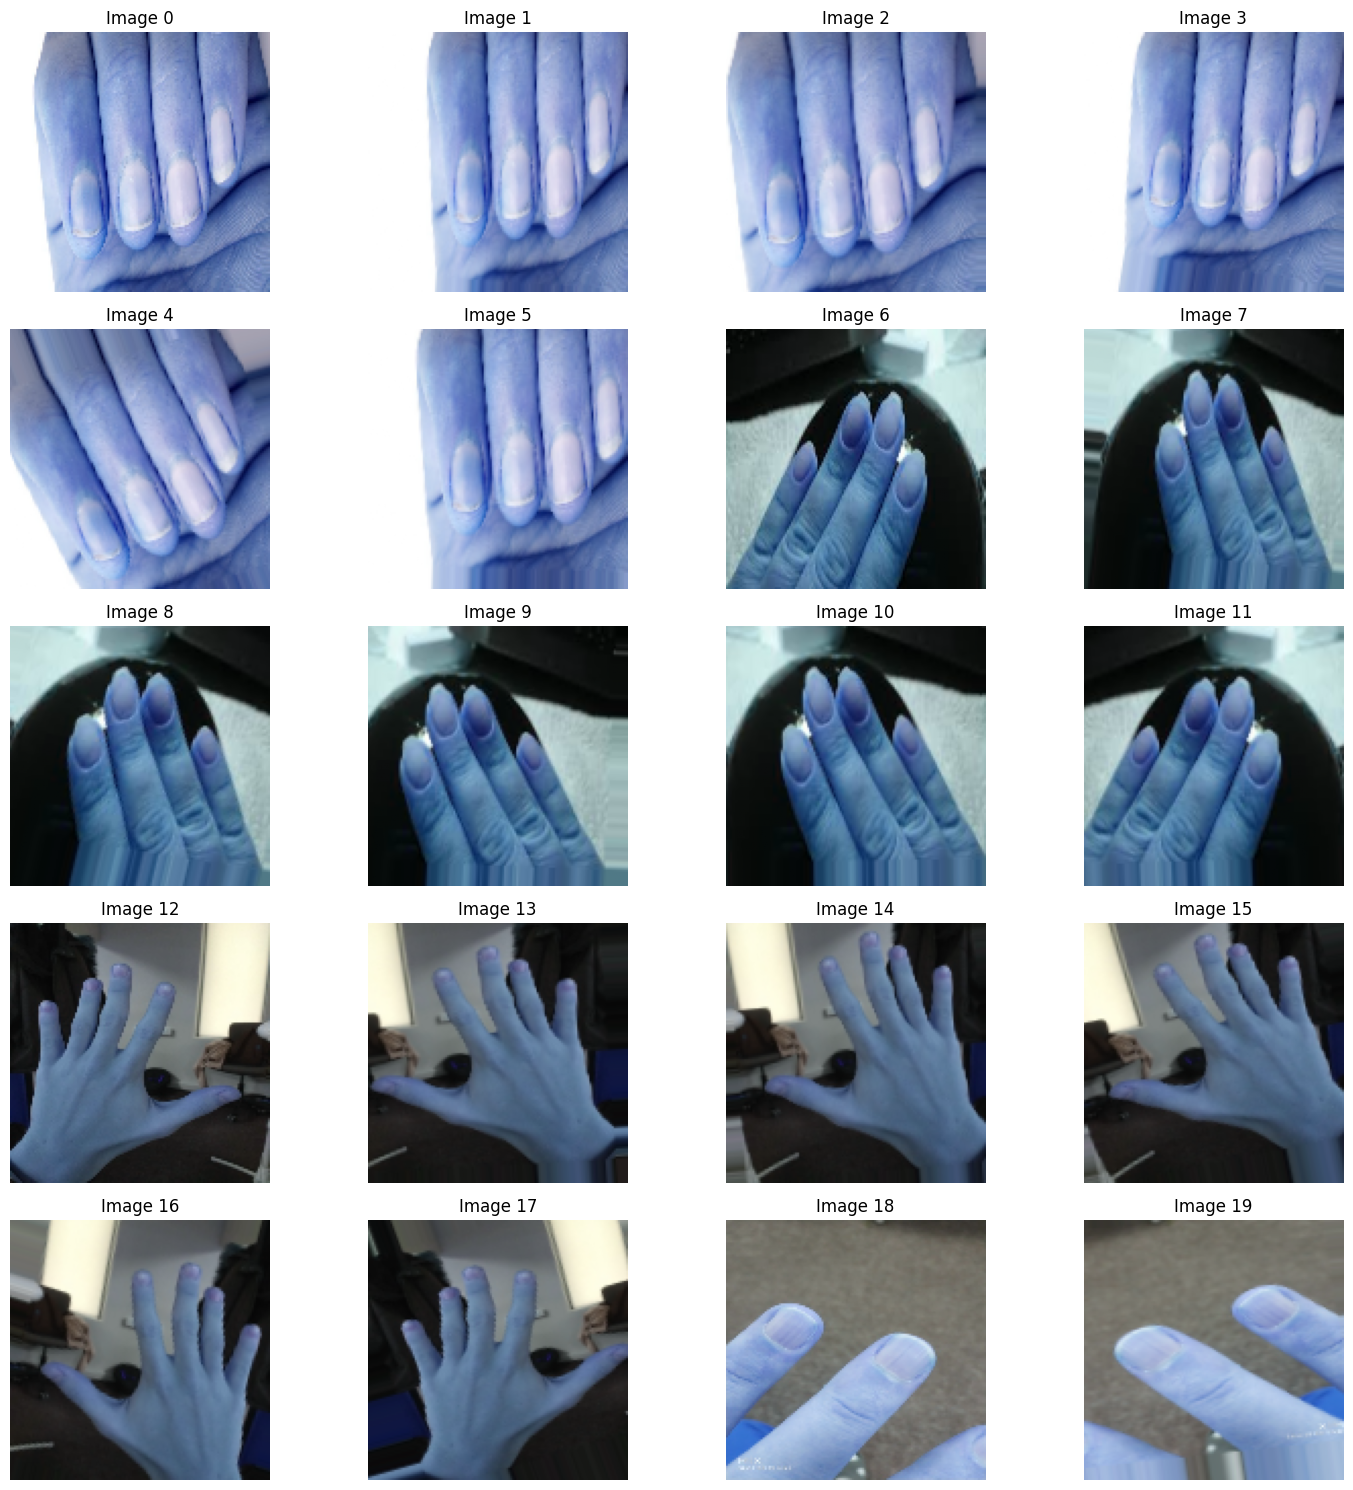

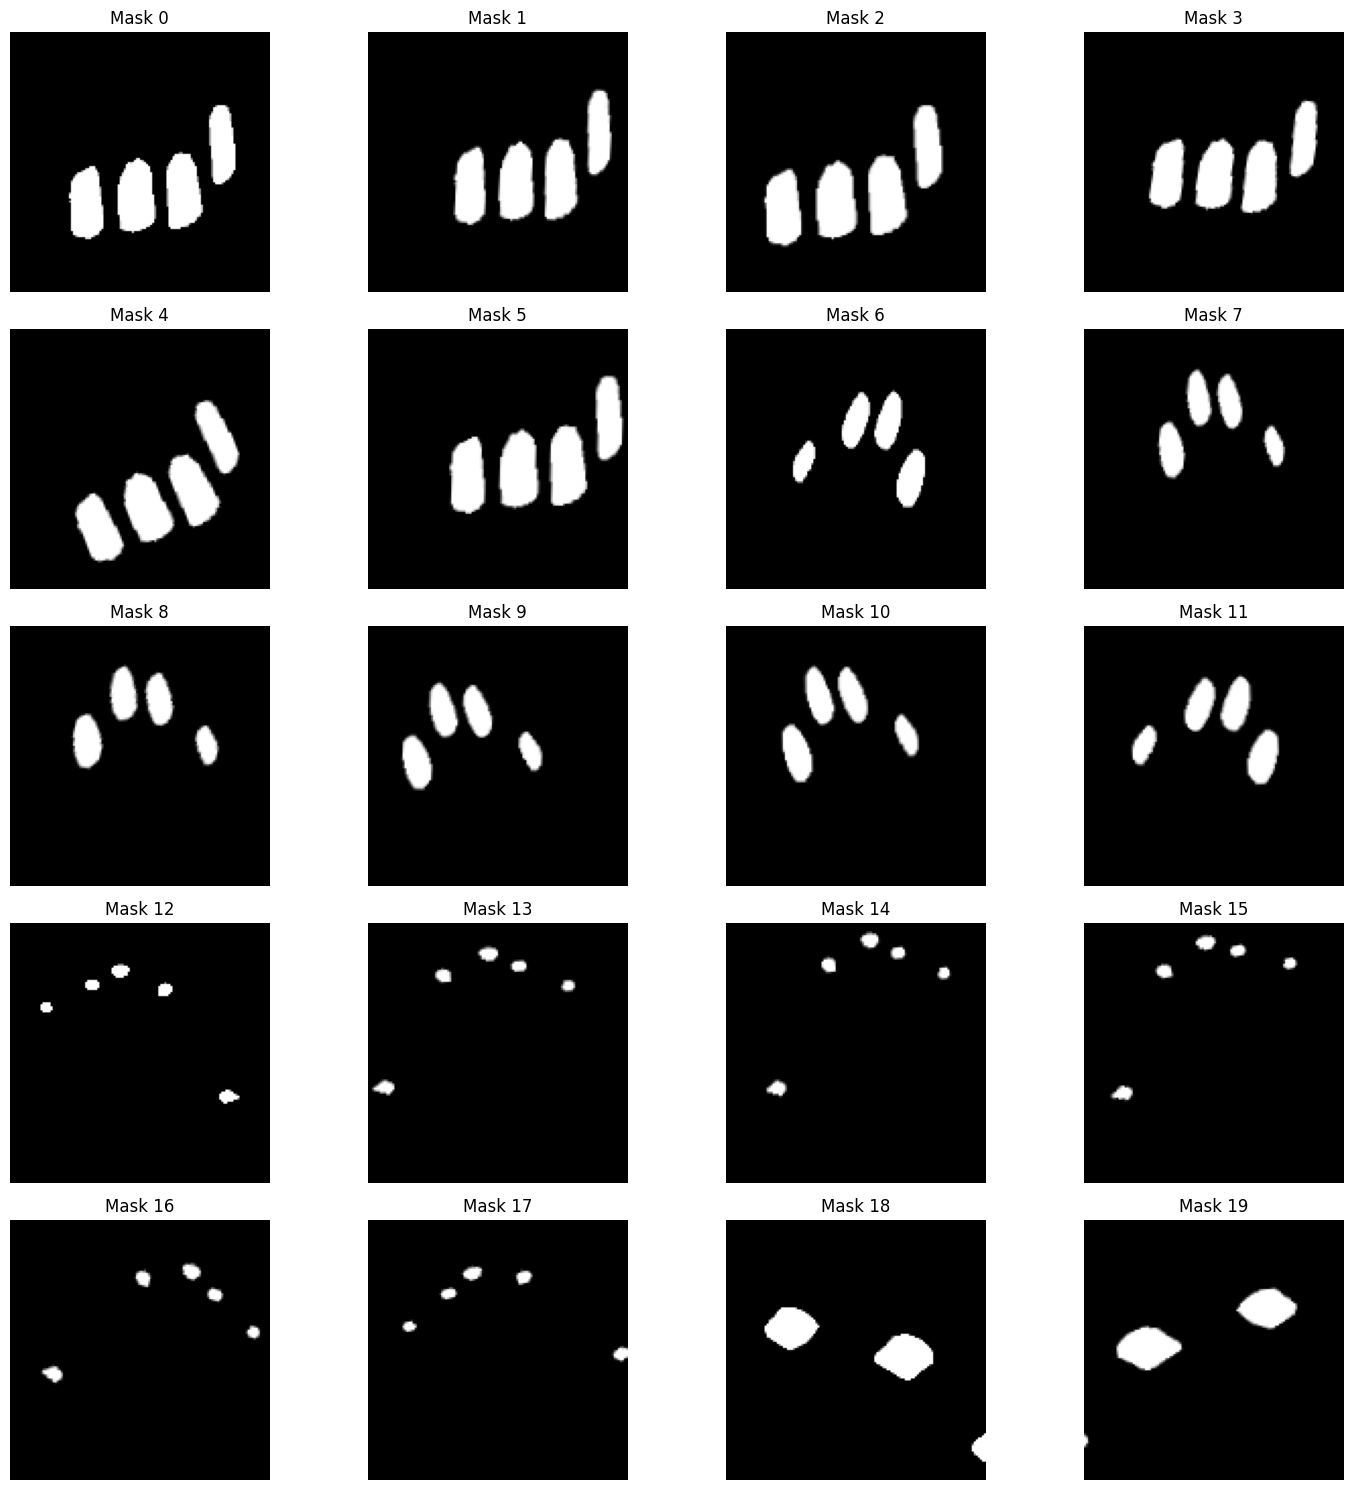

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f"Image {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 15))
for i in range(20):
    plt.subplot(5, 4, i + 1)
    plt.imshow(augmented_masks[i], cmap='gray')
    plt.title(f"Mask {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Проверка размеров
print(f"Training images shape: {X_train.shape}")
print(f"Training masks shape: {y_train.shape}")
print(f"Testing images shape: {X_test.shape}")
print(f"Testing masks shape: {y_test.shape}")

Training images shape: (249, 49152)
Training masks shape: (249,)
Testing images shape: (63, 49152)
Testing masks shape: (63,)


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Обучение модели
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop])

# Оценка модели на тестовых данных
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Accuracy on test data: {test_acc:.4f}')

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.7765 - loss: 0.3708 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 1.0000 - loss: 1.0922e-06 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 2.3591e-15 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Accuracy on test data: 1.0000


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


ValueError: num must be an integer with 1 <= num <= 20, not 21

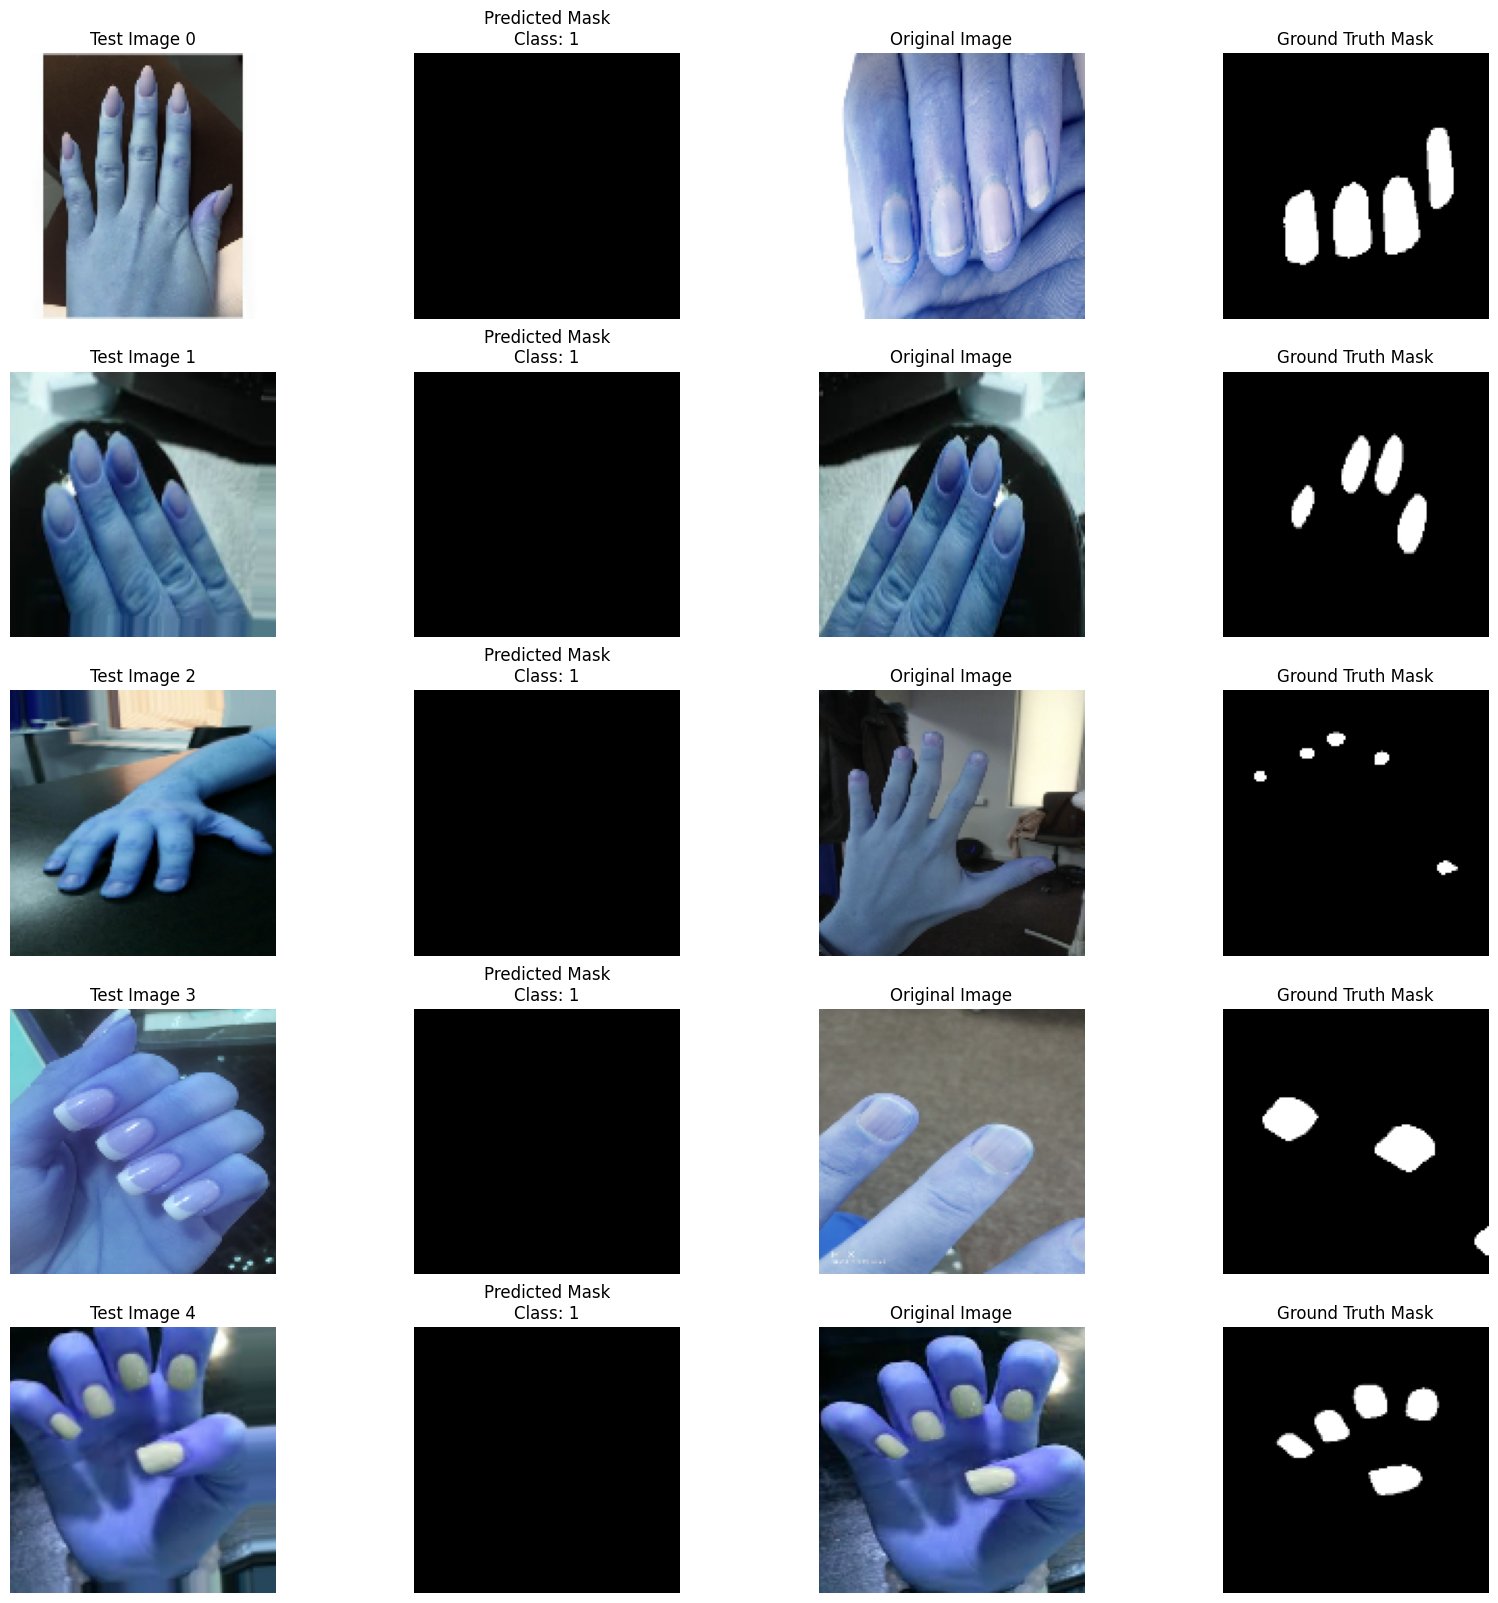

In [ ]:
# Предсказания на тестовых данных
predictions = model.predict(X_test)
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Создание предсказанных масок
predicted_masks = np.zeros_like(X_test[:, :128 * 128])  # Создаем массив нулевых масок
for i, pred_class in enumerate(predicted_classes):
    if pred_class == 1:
        predicted_masks[i] = 1  # Если объект есть, заполняем маску единицами

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 4, 4 * i + 1)
    plt.imshow(X_test[i].reshape(128, 128, 3))
    plt.title(f"Test Image {i}")
    plt.axis('off')

    plt.subplot(5, 4, 4 * i + 2)
    plt.imshow(predicted_masks[i].reshape(128, 128), cmap='gray')
    plt.title(f"Predicted Mask\nClass: {predicted_classes[i]}")
    plt.axis('off')

    plt.subplot(5, 4, 4 * i + 3)
    plt.imshow(cv2.resize(images[i % len(images)], (128, 128)))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(5, 4, 4 * i + 4)
    plt.imshow(cv2.resize(masks[i % len(masks)], (128, 128)), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def build_segmentation_model(input_shape=(128, 128, 3)):
    model = Sequential([
        # Encoder
        Conv2D(64, 3, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, 3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, 3, activation='relu', padding='same'),
        BatchNormalization(),

        # Decoder
        UpSampling2D(size=(2, 2)),
        Conv2D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),

        UpSampling2D(size=(2, 2)),
        Conv2D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, 3, activation='relu', padding='same'),
        BatchNormalization(),

        # Выходной слой
        Conv2D(1, 1, activation='sigmoid')
    ])

    return model

# Создание модели
model = build_segmentation_model(input_shape=(128, 128, 3))

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', MeanIoU(num_classes=2)])

X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_masks, test_size=0.2, random_state=42)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 230s 31s/step - accuracy: 0.5301 - loss: 0.8015 - mean_io_u_4: 0.4810 - val_accuracy: 0.9192 - val_loss: 0.6547 - val_mean_io_u_4: 0.4730
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 266s 32s/step - accuracy: 0.7338 - loss: 0.6421 - mean_io_u_4: 0.4813 - val_accuracy: 0.9031 - val_loss: 0.5463 - val_mean_io_u_4: 0.4730
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 251s 30s/step - accuracy: 0.8773 - loss: 0.5879 - mean_io_u_4: 0.4852 - val_accuracy: 0.9123 - val_loss: 0.5613 - val_mean_io_u_4: 0.4730
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 266s 31s/step - accuracy: 0.9122 - loss: 0.5422 - mean_io_u_4: 0.5167 - val_accuracy: 0.9197 - val_loss: 0.5275 - val_mean_io_u_4: 0.4730
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 264s 31s/step - accuracy: 0.9223 - loss: 0.4976 - mean_io_u_4: 0.5531 - val_accuracy: 0.9167 - val_loss: 0.4692 - val_mean_io_u_4: 0.4730
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 215s 31s/step - accuracy: 0.9197 - loss: 0.4904 - mean_io_u_4: 0.5553 - val_accuracy: 0.4913 -

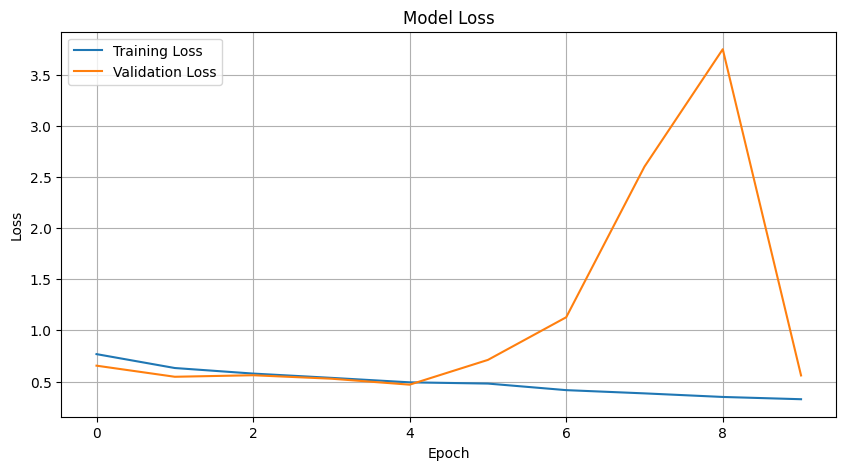

In [ ]:
# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

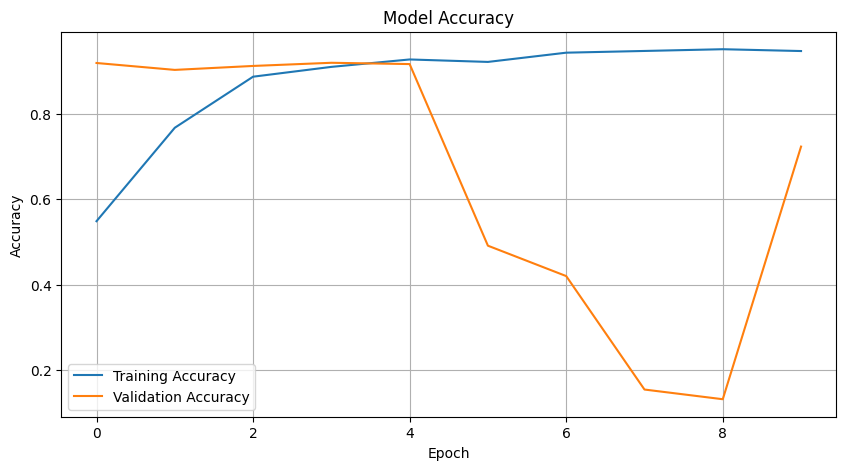

In [ ]:
# Построение графика точности
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step


ValueError: num must be an integer with 1 <= num <= 20, not 21

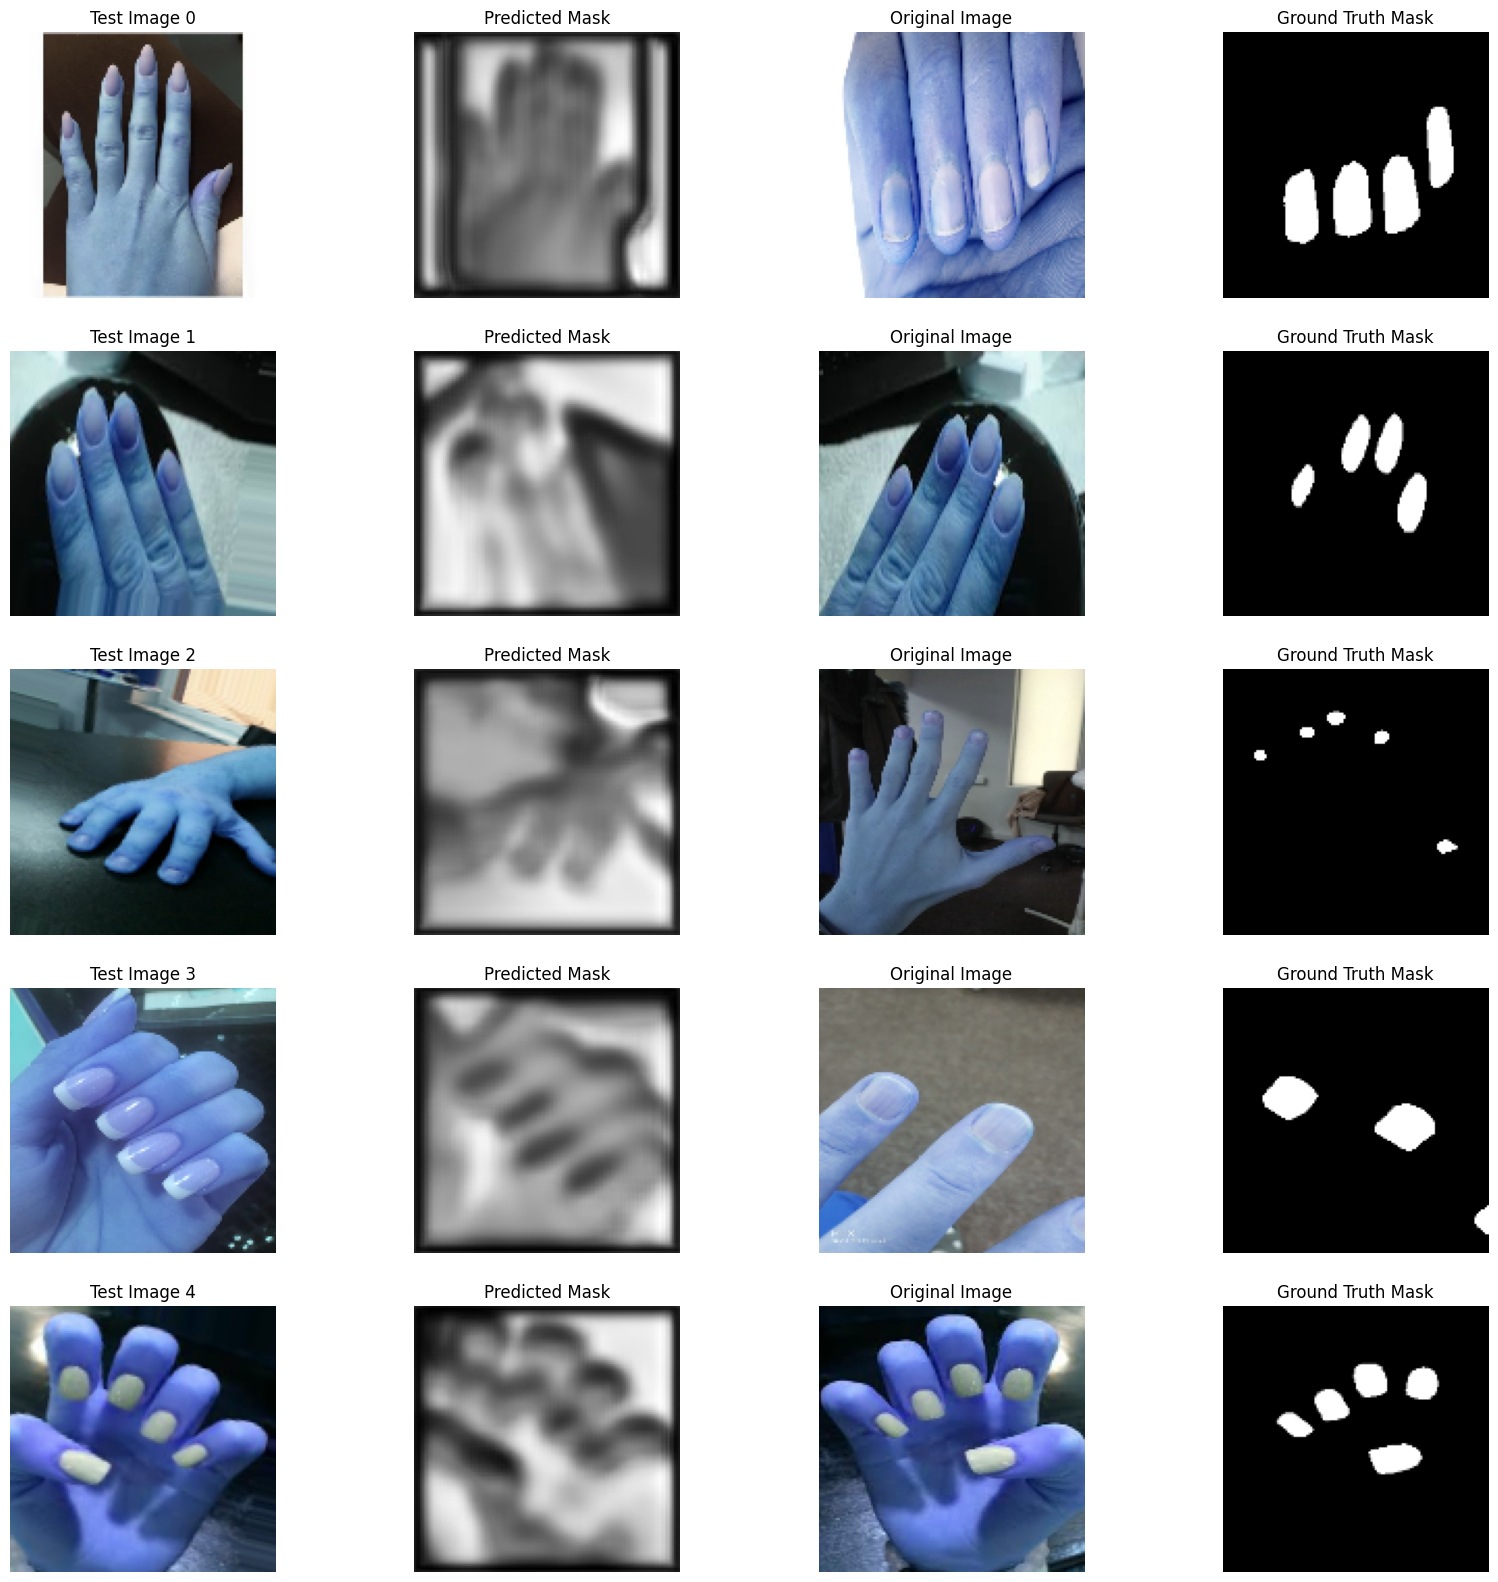

In [ ]:
# Предсказания на тестовых данных
predictions = model.predict(X_test)

# Визуализация первых 10 тестовых изображений с предсказанными масками
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 4, 4 * i + 1)
    plt.imshow(X_test[i])
    plt.title(f"Test Image {i}")
    plt.axis('off')

    plt.subplot(5, 4, 4 * i + 2)
    plt.imshow(predictions[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(5, 4, 4 * i + 3)
    plt.imshow(cv2.resize(images[i % len(images)], (128, 128)))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(5, 4, 4 * i + 4)
    plt.imshow(cv2.resize(masks[i % len(masks)], (128, 128)), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Обучение модели
history1 = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop, checkpoint])

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.5145 - loss: 0.8195 - mean_io_u: 0.4809 

7/7 ━━━━━━━━━━━━━━━━━━━━ 251s 34s/step - accuracy: 0.5160 - loss: 0.8140 - mean_io_u: 0.4810 - val_accuracy: 0.9101 - val_loss: 0.6655 - val_mean_io_u: 0.4731
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 240s 30s/step - accuracy: 0.7256 - loss: 0.6446 - mean_io_u: 0.4814 - val_accuracy: 0.3050 - val_loss: 0.9320 - val_mean_io_u: 0.4731
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 256s 30s/step - accuracy: 0.8583 - loss: 0.5994 - mean_io_u: 0.4824 - val_accuracy: 0.6254 - val_loss: 0.7001 - val_mean_io_u: 0.4731
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.9180 - loss: 0.5561 - mean_io_u: 0.4853 

7/7 ━━━━━━━━━━━━━━━━━━━━ 221s 32s/step - accuracy: 0.9181 - loss: 0.5548 - mean_io_u: 0.4854 - val_accuracy: 0.6672 - val_loss: 0.6615 - val_mean_io_u: 0.4731
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.9271 - loss: 0.5055 - mean_io_u: 0.5097 

7/7 ━━━━━━━━━━━━━━━━━━━━ 257s 31s/step - accuracy: 0.9276 - loss: 0.5052 - mean_io_u: 0.5108 - val_accuracy: 0.8927 - val_loss: 0.4667 - val_mean_io_u: 0.4731
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 270s 32s/step - accuracy: 0.9442 - loss: 0.4690 - mean_io_u: 0.5548 - val_accuracy: 0.6623 - val_loss: 0.5532 - val_mean_io_u: 0.4731
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.9417 - loss: 0.4231 - mean_io_u: 0.5844 

7/7 ━━━━━━━━━━━━━━━━━━━━ 217s 31s/step - accuracy: 0.9420 - loss: 0.4215 - mean_io_u: 0.5858 - val_accuracy: 0.9171 - val_loss: 0.4146 - val_mean_io_u: 0.4731
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 254s 29s/step - accuracy: 0.9517 - loss: 0.3777 - mean_io_u: 0.6044 - val_accuracy: 0.7069 - val_loss: 0.6523 - val_mean_io_u: 0.4731
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 216s 31s/step - accuracy: 0.9530 - loss: 0.3464 - mean_io_u: 0.6131 - val_accuracy: 0.1360 - val_loss: 2.8623 - val_mean_io_u: 0.4731
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 260s 30s/step - accuracy: 0.9587 - loss: 0.3028 - mean_io_u: 0.6349 - val_accuracy: 0.1673 - val_loss: 2.0380 - val_mean_io_u: 0.4731
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 265s 31s/step - accuracy: 0.9574 - loss: 0.2805 - mean_io_u: 0.6412 - val_accuracy: 0.4220 - val_loss: 1.1508 - val_mean_io_u: 0.4731
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.9572 - loss: 0.2725 - mean_io_u: 0.6199 

7/7 ━━━━━━━━━━━━━━━━━━━━ 262s 31s/step - accuracy: 0.9572 - loss: 0.2724 - mean_io_u: 0.6211 - val_accuracy: 0.9221 - val_loss: 0.2658 - val_mean_io_u: 0.4731
Epoch 13/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 216s 31s/step - accuracy: 0.9565 - loss: 0.2650 - mean_io_u: 0.6212 - val_accuracy: 0.9201 - val_loss: 0.3532 - val_mean_io_u: 0.4731
Epoch 14/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.9552 - loss: 0.2489 - mean_io_u: 0.6089 

7/7 ━━━━━━━━━━━━━━━━━━━━ 211s 30s/step - accuracy: 0.9554 - loss: 0.2479 - mean_io_u: 0.6098 - val_accuracy: 0.9221 - val_loss: 0.2473 - val_mean_io_u: 0.4731
Epoch 15/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 217s 31s/step - accuracy: 0.9572 - loss: 0.2227 - mean_io_u: 0.6427 - val_accuracy: 0.6856 - val_loss: 0.5748 - val_mean_io_u: 0.4731
Epoch 16/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 256s 30s/step - accuracy: 0.9590 - loss: 0.2009 - mean_io_u: 0.6244 - val_accuracy: 0.9220 - val_loss: 0.2597 - val_mean_io_u: 0.4731
Epoch 17/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 258s 29s/step - accuracy: 0.9612 - loss: 0.1762 - mean_io_u: 0.6779 - val_accuracy: 0.5463 - val_loss: 0.9291 - val_mean_io_u: 0.4731
Epoch 18/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 275s 31s/step - accuracy: 0.9624 - loss: 0.1610 - mean_io_u: 0.6491 - val_accuracy: 0.9220 - val_loss: 0.2714 - val_mean_io_u: 0.4731
Epoch 19/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 261s 31s/step - accuracy: 0.9638 - loss: 0.1531 - mean_io_u: 0.6562 - val_accuracy: 0.9221 - val_loss: 0.2643 - val_mean

7/7 ━━━━━━━━━━━━━━━━━━━━ 249s 29s/step - accuracy: 0.9636 - loss: 0.1438 - mean_io_u: 0.6827 - val_accuracy: 0.9221 - val_loss: 0.2431 - val_mean_io_u: 0.4731
Epoch 21/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.9649 - loss: 0.1290 - mean_io_u: 0.6582 

7/7 ━━━━━━━━━━━━━━━━━━━━ 271s 31s/step - accuracy: 0.9649 - loss: 0.1286 - mean_io_u: 0.6596 - val_accuracy: 0.9221 - val_loss: 0.2423 - val_mean_io_u: 0.4731
Epoch 22/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.9655 - loss: 0.1131 - mean_io_u: 0.7091 

7/7 ━━━━━━━━━━━━━━━━━━━━ 254s 29s/step - accuracy: 0.9655 - loss: 0.1138 - mean_io_u: 0.7087 - val_accuracy: 0.9221 - val_loss: 0.2360 - val_mean_io_u: 0.4731
Epoch 23/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 259s 29s/step - accuracy: 0.9677 - loss: 0.1073 - mean_io_u: 0.6963 - val_accuracy: 0.9221 - val_loss: 0.2691 - val_mean_io_u: 0.4731
Epoch 24/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 215s 30s/step - accuracy: 0.9682 - loss: 0.0994 - mean_io_u: 0.7191 - val_accuracy: 0.9221 - val_loss: 0.2527 - val_mean_io_u: 0.4731
Epoch 25/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 215s 30s/step - accuracy: 0.9667 - loss: 0.0912 - mean_io_u: 0.7186 - val_accuracy: 0.9221 - val_loss: 0.2504 - val_mean_io_u: 0.4731
Epoch 26/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 214s 30s/step - accuracy: 0.9686 - loss: 0.0925 - mean_io_u: 0.7063 - val_accuracy: 0.9221 - val_loss: 0.2799 - val_mean_io_u: 0.4731
Epoch 27/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 251s 29s/step - accuracy: 0.9673 - loss: 0.0901 - mean_io_u: 0.7157 - val_accuracy: 0.9221 - val_loss: 0.2457 - val_mean

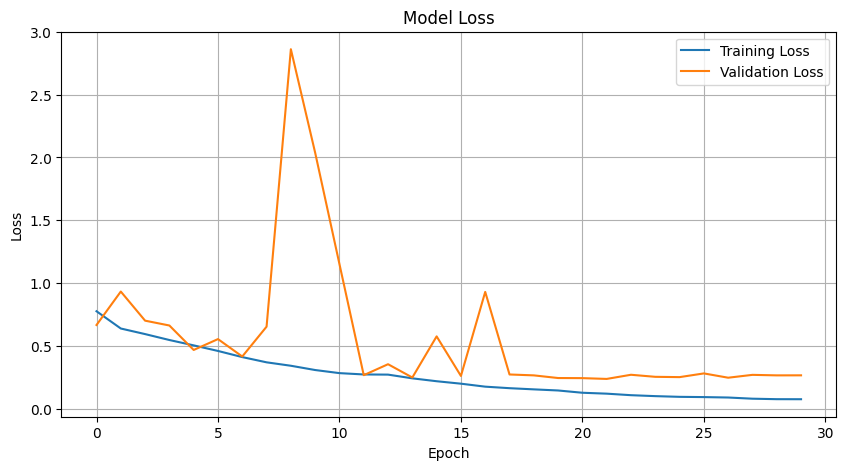

In [ ]:
# Построение графика потерь
plt.figure(figsize=(10, 5))
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

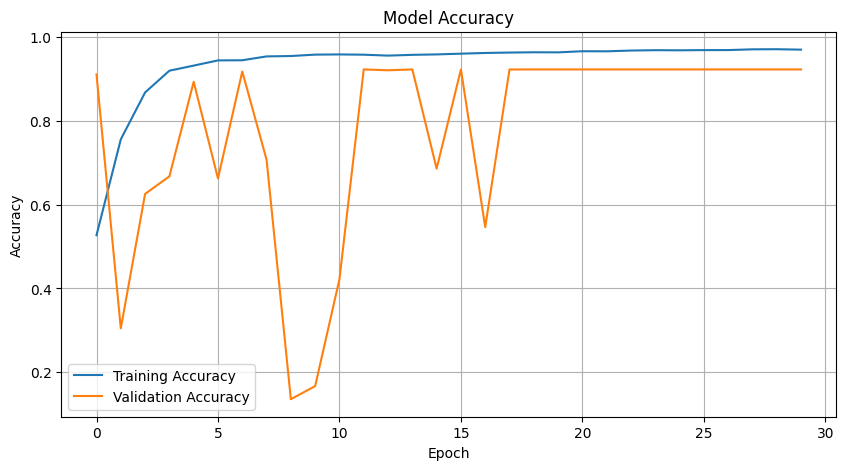

In [ ]:
# Построение графика точности
plt.figure(figsize=(10, 5))
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step


ValueError: num must be an integer with 1 <= num <= 20, not 21

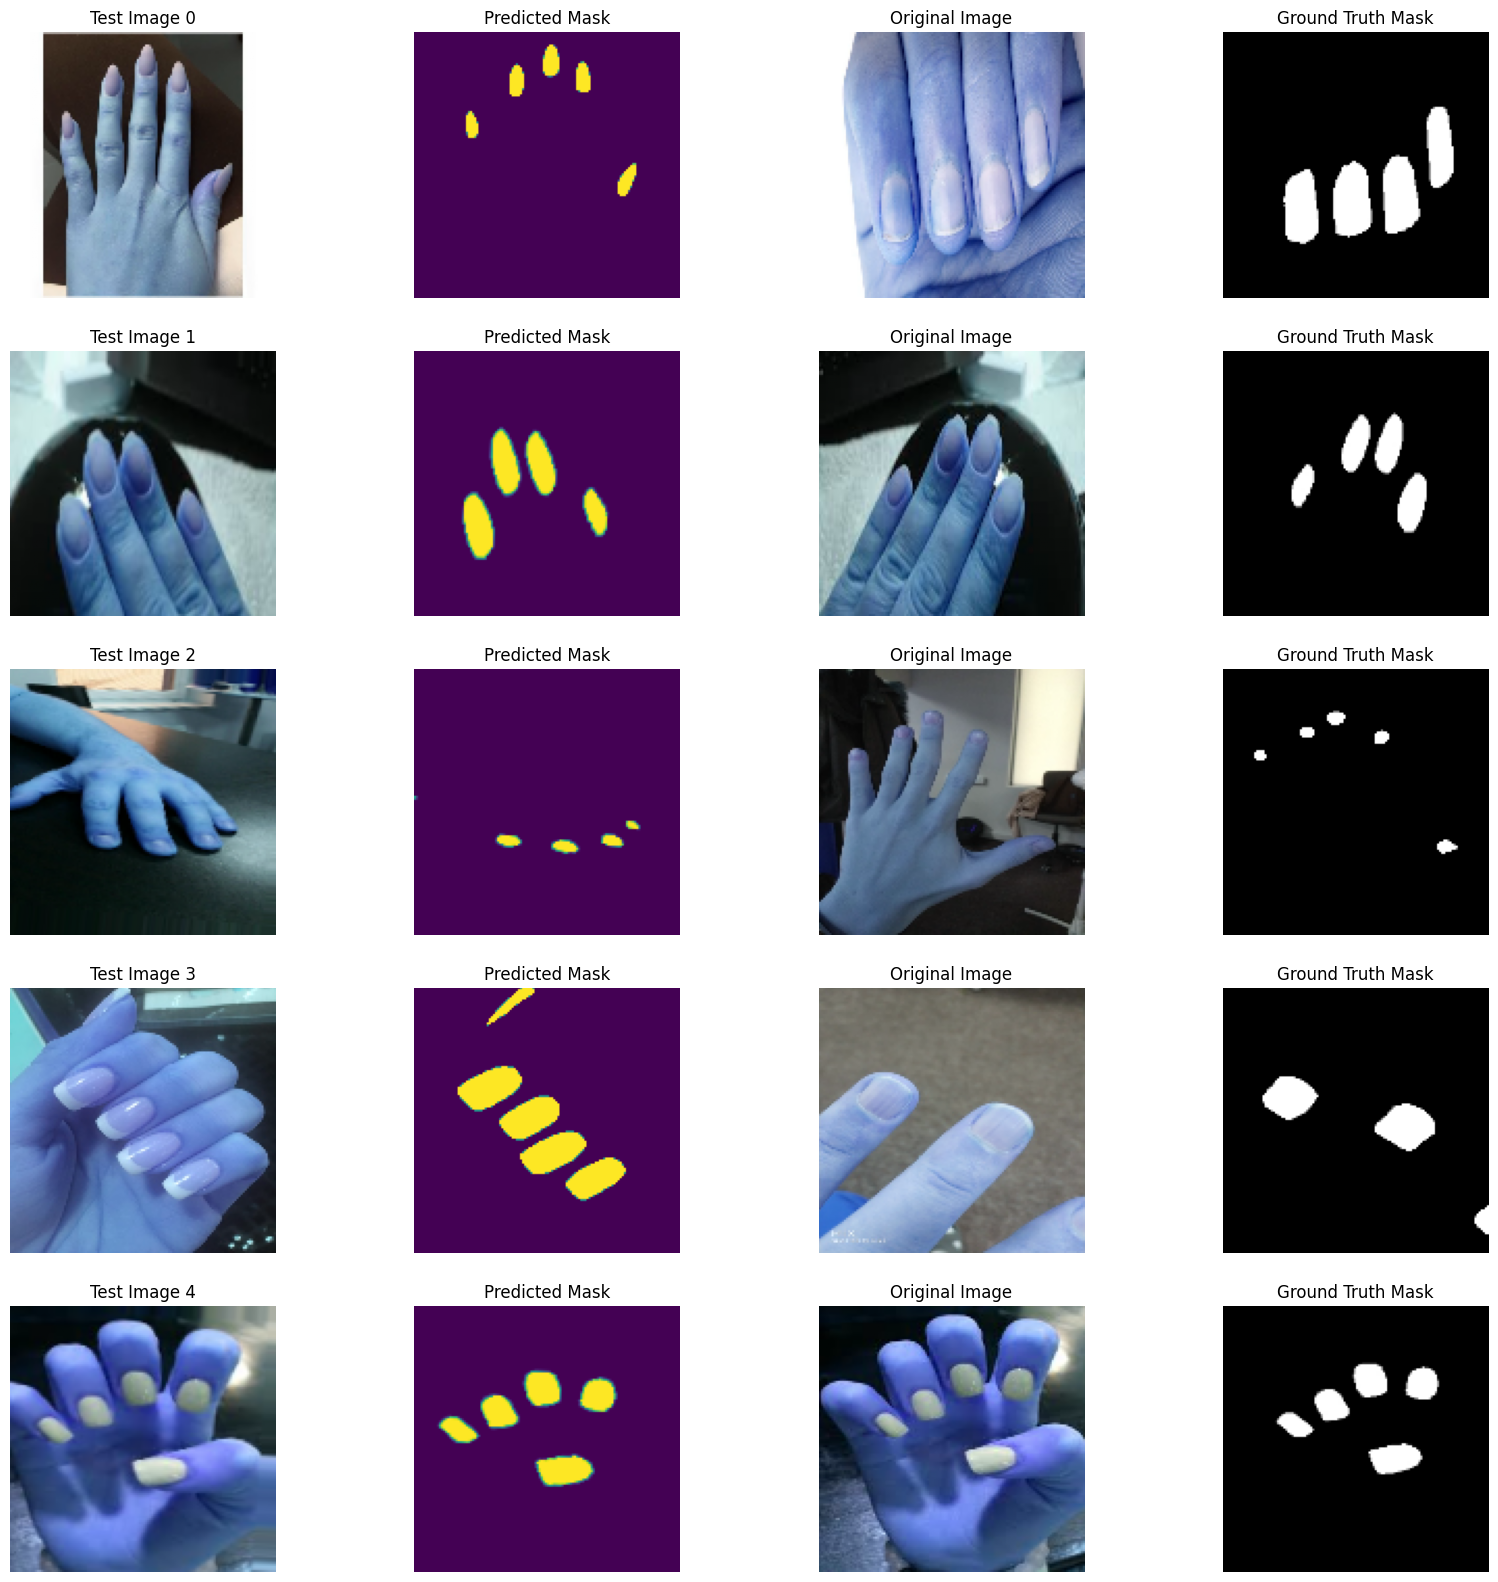

In [ ]:
# Предсказания на тестовых данных
predictions = model.predict(X_test)

# Визуализация первых 10 тестовых изображений с предсказанными масками
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5, 4, 4 * i + 1)
    plt.imshow(X_test[i])
    plt.title(f"Test Image {i}")
    plt.axis('off')

    plt.subplot(5, 4, 4 * i + 2)
    plt.imshow(predictions[i].squeeze())
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(5, 4, 4 * i + 3)
    plt.imshow(cv2.resize(images[i % len(images)], (128, 128)))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(5, 4, 4 * i + 4)
    plt.imshow(cv2.resize(masks[i % len(masks)], (128, 128)), cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()